<a href="https://colab.research.google.com/github/yuhui-0611/ESAA/blob/main/ESAA_YB_WEEK11_1_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 9. 회귀 실습 - 자전거 대여 수요 예측

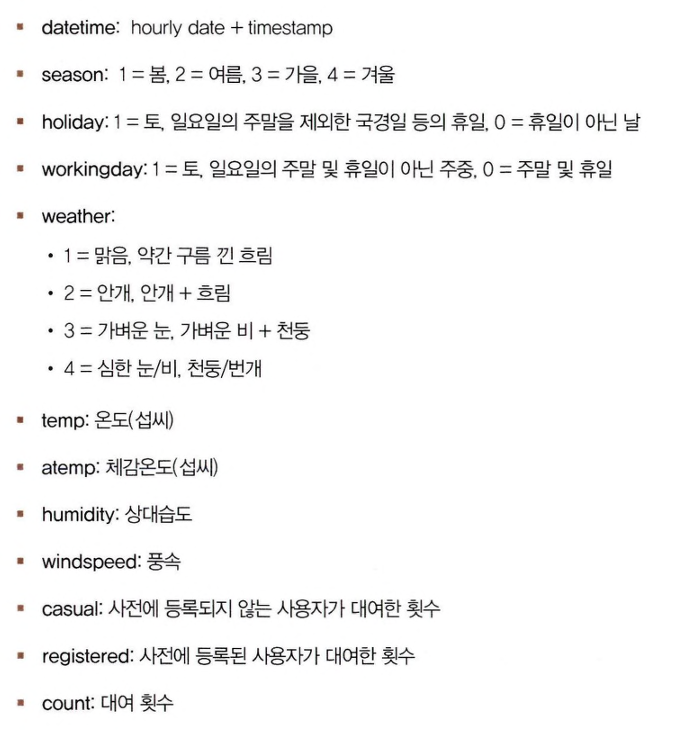

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터 클렌징 및 가공 & 데이터 시각화

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

bike_df = pd.read_csv("/content/drive/MyDrive/ESAA/bike_train.csv")
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [4]:
# 문자열 datetime 타입으로 변경
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x: x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x: x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [5]:
# casual + registered = count 이기에 삭제
drop_columns = ['datetime', 'casual', 'registered']
bike_df.drop(drop_columns, axis=1, inplace=True)

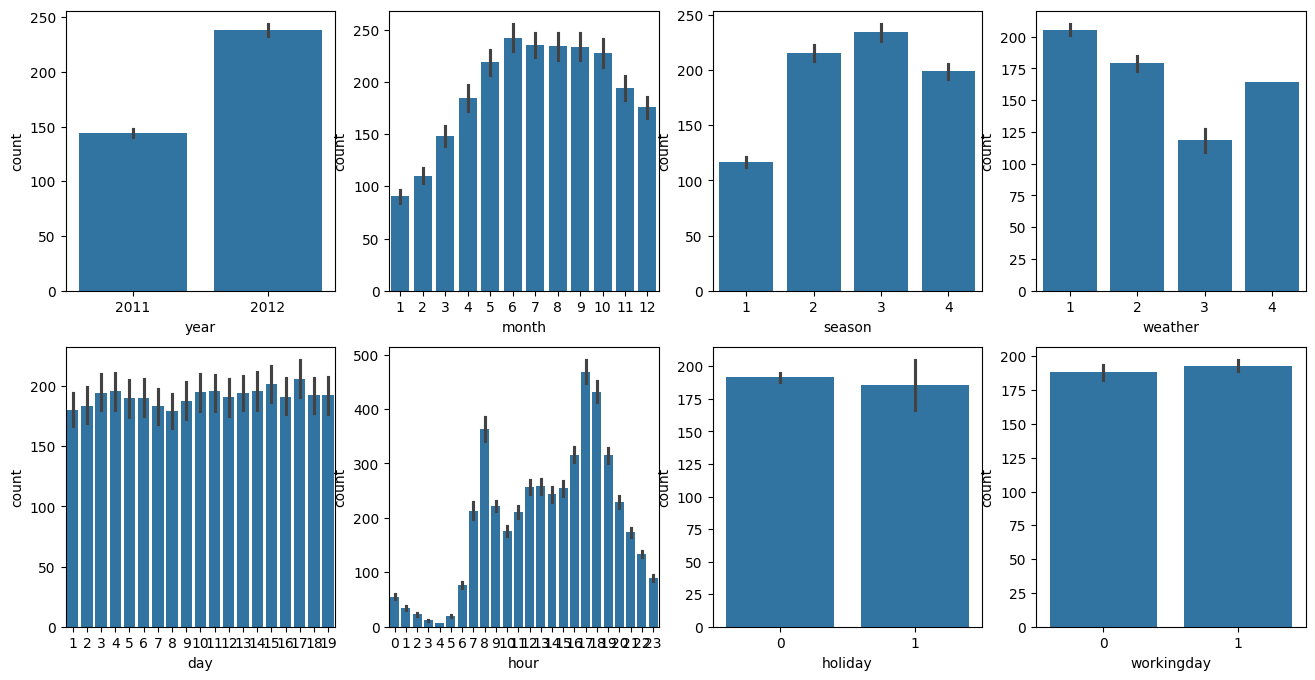

In [6]:
fig, axs = plt.subplots(figsize=(16,8), ncols=4, nrows=2)
cat_features = ['year','month','season','weather','day','hour','holiday','workingday']

# cat_features에 있는 모든 칼럼별로 개별 칼럼값에 따른 count의 합을 barplot으로 시각화
for i, feature in enumerate(cat_features):
  row = int(i/4)
  col = i%4   # 나머지 추출
  # 시본의 barplot을 이용해 칼럼값에 따른 count의 합을 표현
  sns.barplot(x=feature, y='count', data=bike_df, ax=axs[row][col])

- year별 count를 보면 2012년이 2011년보다 상대적으로 값이 높음 > 이는 시간이 지날수록 자전거 대여 횟수가 지속적으로 증가한 결과
- month의 경우 1, 2, 3월이 낮고, 6, 7, 8, 9월이 높음
- season을 보면 봄(1), 겨울(4)이 낮고, 여름(2), 가을(3)이 높음
- weather의 경우는 눈 또는 비가 있는 경우(3,4)가 낮고, 맑거나(1) 약간 안개가 있는 경우(2)가 높음
- hour의 경우는 오전 출근 시간(8)과 오후 퇴근 시간(17,18)이 상대적으로 높음
- day 간의 차이는 크지 않으며, holiday 또는 workingday는 주중일 경우(즉 holiday는 0, workingday는 1)가 상대적으로 약간 높음

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산
def rmsle(y,pred):
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y - log_pred) ** 2
  rmsle = np.sqrt(np.mean(squared_error))
  return rmsle

# 사이킷런의 mean_squared_error( )를 이용해 RMSE 계산
def rmse(y, pred):
  return np.sqrt(mean_squared_error(y, pred))

# MAE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y, pred):
  rmsle_val = rmsle(y, pred)
  rmse_val = rmse(y, pred)
  # MAE는 사이킷런의 mean_absolute_error()로 계산
  mae_val = mean_absolute_error(y, pred)
  print('MAE: {0:.3f}, RMSE: {1:.3f}, RMSLE: {2:.3f}'.format(mae_val, rmse_val, rmsle_val))

In [8]:
# 다음과 같은 rmsle 구현은 오버플로나 언더플로 오류를 발생하기 쉽다.
# def rmsle(y,pred):
#   msle = mean_squared_log_error(y,pred)
#   rmsle = np.sqrt(mse)
#   return rmsle

## 로그 변환, 피처 인코딩과 모델 학습/예측/평가

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

MAE: 105.924, RMSE: 140.900, RMSLE: 1.165


- 실제 Target 데이터 값인 대여 횟수(Count)를 감안하면 예측 오류로서는 비교적 큰 값
- 아래 코드로 오류 값이 가장 큰 5개 확인

In [10]:
def get_top_error_data(y_test, pred, n_tops=5):
  # DataFrame의 칼럼으로 실제 대여 횟수와 예측값을 서로 비교할 수 있도록 생성
  result_df = pd.DataFrame(y_test.values, columns=['real_count'])
  result_df['predicted_count'] = np.round(pred)
  result_df['diff'] = np.abs(result_df['predicted_count'] - result_df['real_count'])

  # 예측값과 실제 값 차이가 가장 큰 데이터 순으로 출력
  print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
966          884            327.0  557.0
3151         798            241.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


<Axes: >

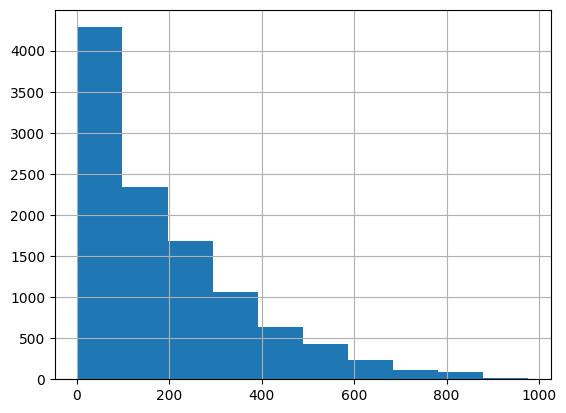

In [11]:
y_target.hist()

- count 칼럼이 정규 분포가 아닌 0~200 사이에 왜곡되어 있음
- 로그 변환으로 정규 분포 형태로 변환

<Axes: >

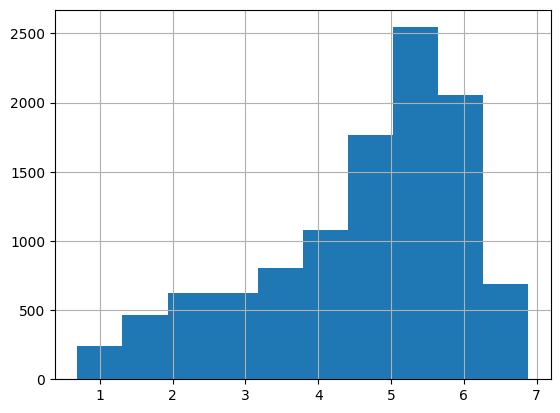

In [12]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [13]:
y_target_log = np.log1p(y_target)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 세트의 Target 값은 로그 변환되었으므로 다시 expm1을 이용해 원래 스케일로 변환
y_test_exp = np.expm1(y_test)

# 예측값 역시 로그 변환된 타깃 기반으로 학습되어 예측했으므로 다시 expm1로 스케일 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

MAE: 109.286, RMSE: 162.594, RMSLE: 1.017


- RMSLE 오류는 줄어들었지만, RMSE는 오히려 더 늘어남

<Axes: ylabel='None'>

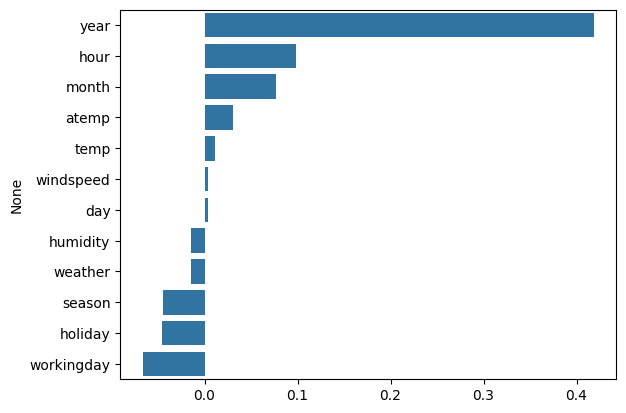

In [14]:
# 회귀 계숫값 시각화
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

- year, hour, month, season, holiday, workingday 피처들의 회귀 계수 영향도가 상대적으로 높음
- 이 피처들을 살펴보면 year는 2011, 2012 값으로, month는 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12와 같이 숫잣값 형태로 의미를 담고 있음
- 하지만 이 피처들의 경우 개별 숫자값의 크기가 의미 있는 것이 아님
- Year의 경우 단순히 연도를 뜻하는 것이므로 2012라는 값이 2011보다 큰 값으로 인식되어서는 안 됨
- 즉 year, hour, month 등은 숫자 값으로 표현되었지만 이들은 모두 카테고리(Category)형 피처임

- 사이킷런은 카테고리만을 위한 데이터 타입이 없으며, 모두 숫자로 변환해야 함
- 하지만 이처럼 숫자형 카테고리 값을 선형 회귀에 사용할 경우, 회귀 계수를 연산할 때 이 숫자형 값에 크게 영향을 받는 경우가 발생할 수 있음
- 따라서 선형 회귀에서는 이러한 피처 인코딩에 원-핫 인코딩을 적용해 변환해야 함

In [15]:
# 'year','month','day','hour' 등의 피처들을 one-hot encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year','month','day','hour',
                                                     'holiday','workingday','season','weather'])

In [16]:
X_features_ohe

,temp,atemp,humidity,windspeed,year_2011,year_2012,month_1,month_2,month_3,month_4,...,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,9.84,14.395,81,0.0000,True,False,True,False,False,False,...,True,False,True,False,False,False,True,False,False,False
1,9.02,13.635,80,0.0000,True,False,True,False,False,False,...,True,False,True,False,False,False,True,False,False,False
2,9.02,13.635,80,0.0000,True,False,True,False,False,False,...,True,False,True,False,False,False,True,False,False,False
3,9.84,14.395,75,0.0000,True,False,True,False,False,False,...,True,False,True,False,False,False,True,False,False,False
4,9.84,14.395,75,0.0000,True,False,True,False,False,False,...,True,False,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,15.58,19.695,50,26.0027,False,True,False,False,False,False,...,False,True,False,False,False,True,True,False,False,False
10882,14.76,17.425,57,15.0013,False,True,False,False,False,False,...,False,True,False,False,False,True,True,False,False,False
10883,13.94,15.910,61,15.0013,False,True,False,False,False,False,...,False,True,False,False,False,True,True,False,False,False
10884,13.94,17.425,61,6.0032,False,True,False,False,False,False,...,False,True,False,False,False,True,True,False,False,False


In [17]:
# 원-핫 인코딩이 적용된 피처 데이터 세트 기반으로 학습/예측 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  if is_expm1:
    y_test = np.expm1(y_test)
    pred = np.expm1(pred)
  print('###', model.__class__.__name__,'###')
  evaluate_regr(y_test,pred)
# end of function get_model_predict


# 모델별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
  get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
MAE: 63.382, RMSE: 97.688, RMSLE: 0.590
### Ridge ###
MAE: 63.893, RMSE: 98.529, RMSLE: 0.590
### Lasso ###
MAE: 72.803, RMSE: 113.219, RMSLE: 0.635


- 원-핫 인코딩을 적용하고 나서 선형 회귀의 예측 성능이 많이 향상됨

<Axes: ylabel='None'>

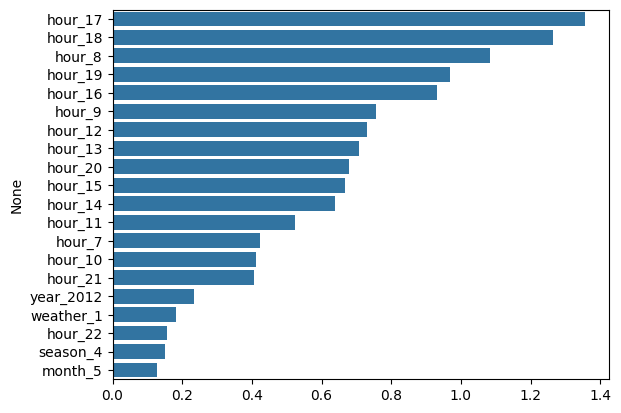

In [18]:
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

- 원-핫 인코딩 후에는 year_2012, year_2011 과 같이 여전히 year 관련 피처들의 회귀 계수 값이 가장 높지만, season_1과 같은 season 관련, weather_1, 2, 3, 4와 같은 weather 관련 속성들의 회귀 계수 값도 상대적으로 커짐
- 원-핫 인코딩을 통해서 피처들의 영향도가 달라졌고, 모델의 성능도 향상됨
- 반드시 그런 것은 아니지만 선형 회귀의 경우 중요 카테고리성 피처들을 원-핫 인코딩으로 변환하는 것은 성능에 중요한 영향을 미칠 수 있음

In [19]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
  get_model_predict(model, X_train.values, X_test.values,
                    y_train.values, y_test.values, is_expm1=True)

### RandomForestRegressor ###
MAE: 31.217, RMSE: 50.423, RMSLE: 0.354
### GradientBoostingRegressor ###
MAE: 32.734, RMSE: 53.332, RMSLE: 0.330
### XGBRegressor ###
MAE: 31.357, RMSE: 51.475, RMSLE: 0.339
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 7620, number of used features: 72
[LightGBM] [Info] Start training from score 4.582043
### LGBMRegressor ###
MAE: 29.029, RMSE: 47.215, RMSLE: 0.319


# 10. 회귀 실습 - 캐글 주택 가격: 고급 회귀 기법

## 데이터 사전 처리(Preprocessing)

In [20]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('/content/drive/MyDrive/ESAA/house_price.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [21]:
print('데이터 세트의 Shape:', house_df.shape)
print('\n전체 피처의 type \n', house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\n Null 칼럼과 그 건수:\n', isnull_series[isnull_series>0].sort_values(ascending=False))

데이터 세트의 Shape: (1460, 81)

전체 피처의 type 
 object     43
int64      35
float64     3
Name: count, dtype: int64

 Null 칼럼과 그 건수:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


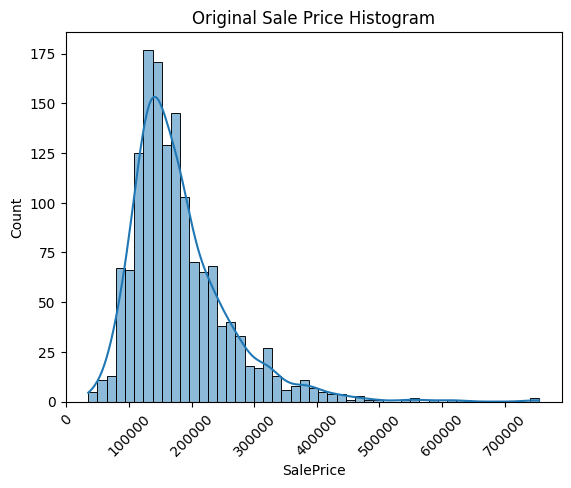

In [22]:
plt.title('Original Sale Price Histogram')
plt.xticks(rotation=45)
sns.histplot(house_df['SalePrice'], kde=True)
plt.show()

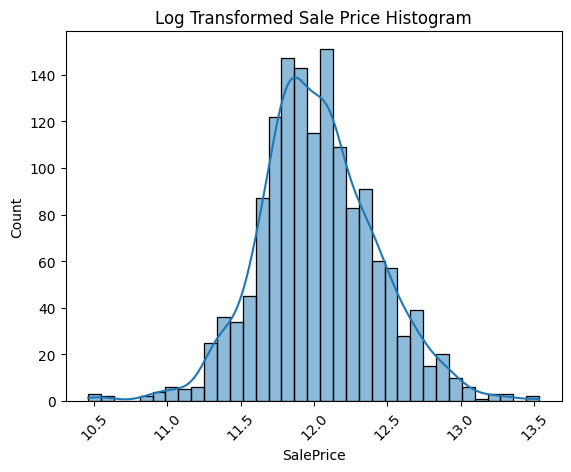

In [23]:
plt.title('Log Transformed Sale Price Histogram')

# 정규 분포 형태 변환
log_SalePrice = np.log1p(house_df['SalePrice'])
plt.xticks(rotation=45)
sns.histplot(log_SalePrice, kde=True)
plt.show()

In [24]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null이 너무 많은 칼럼과 불필요한 칼럼 삭제
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley','Fence','FireplaceQu'], axis=1, inplace=True)

# 드롭하지 않는 숫자형 Null 칼럼은 평균값으로 대체
# select_dtypes : 컬럼의 자료형으로 선택하는 함수
# 숫자형 열만 골라서 평균을 계산
house_df.fillna(house_df.select_dtypes(include='number').mean(), inplace=True)

# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum()>0]
print('## Null 피처의 Type: \n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type: 
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


- 문자형 피처만 Null인 상태
- get_dummies() : 자동으로 문자열 피처를 원-핫 인코딩 변환
> Null 값은 모든 인코딩 값이 0으로 변환되는 방식으로 대체해주므로 별도의 Null 값을 대체하는 로직이 필요 없음

In [25]:
# 원-핫 인코딩을 적용하면 열 개수가 증가하기에 이를 확인
print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shae:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum()>0]
print('## Null 피처의 Type:\n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 Shape: (1460, 75)
get_dummies() 수행 후 데이터 Shae: (1460, 270)
## Null 피처의 Type:
 Series([], dtype: object)


## 선형 회귀 모델 학습/예측/평가

In [26]:
# 단일 모델의 RMSE 반환
def get_rmse(model):
  pred = model.predict(X_test)
  mse = mean_squared_error(y_test, pred)
  rmse = np.sqrt(mse)
  print(model.__class__.__name__, '로그 변환된 RMSE:', np.round(rmse,3))
  return rmse

# 여러 모델의 RMSE 반환
def get_rmses(models):
  rmses = []
  for model in models:
    rmse = get_rmse(model)
    rmses.append(rmse)
  return rmses

In [27]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.127
Lasso 로그 변환된 RMSE: 0.176


[np.float64(0.13183184688250701),
 np.float64(0.1274058283626616),
 np.float64(0.17628250556471403)]

In [28]:
def get_top_bottom_coef(model, n=10):
  # coef_ 속성을 기반으로 Series 객체를 생성 / index는 칼럼명
  coef = pd.Series(model.coef_, index=X_features.columns)

  # 상위 10개, 하위 10개의 회귀 계수를 추출해 반환
  coef_high = coef.sort_values(ascending=False).head(n)
  coef_low = coef.sort_values(ascending=False).tail(n)
  return coef_high, coef_low

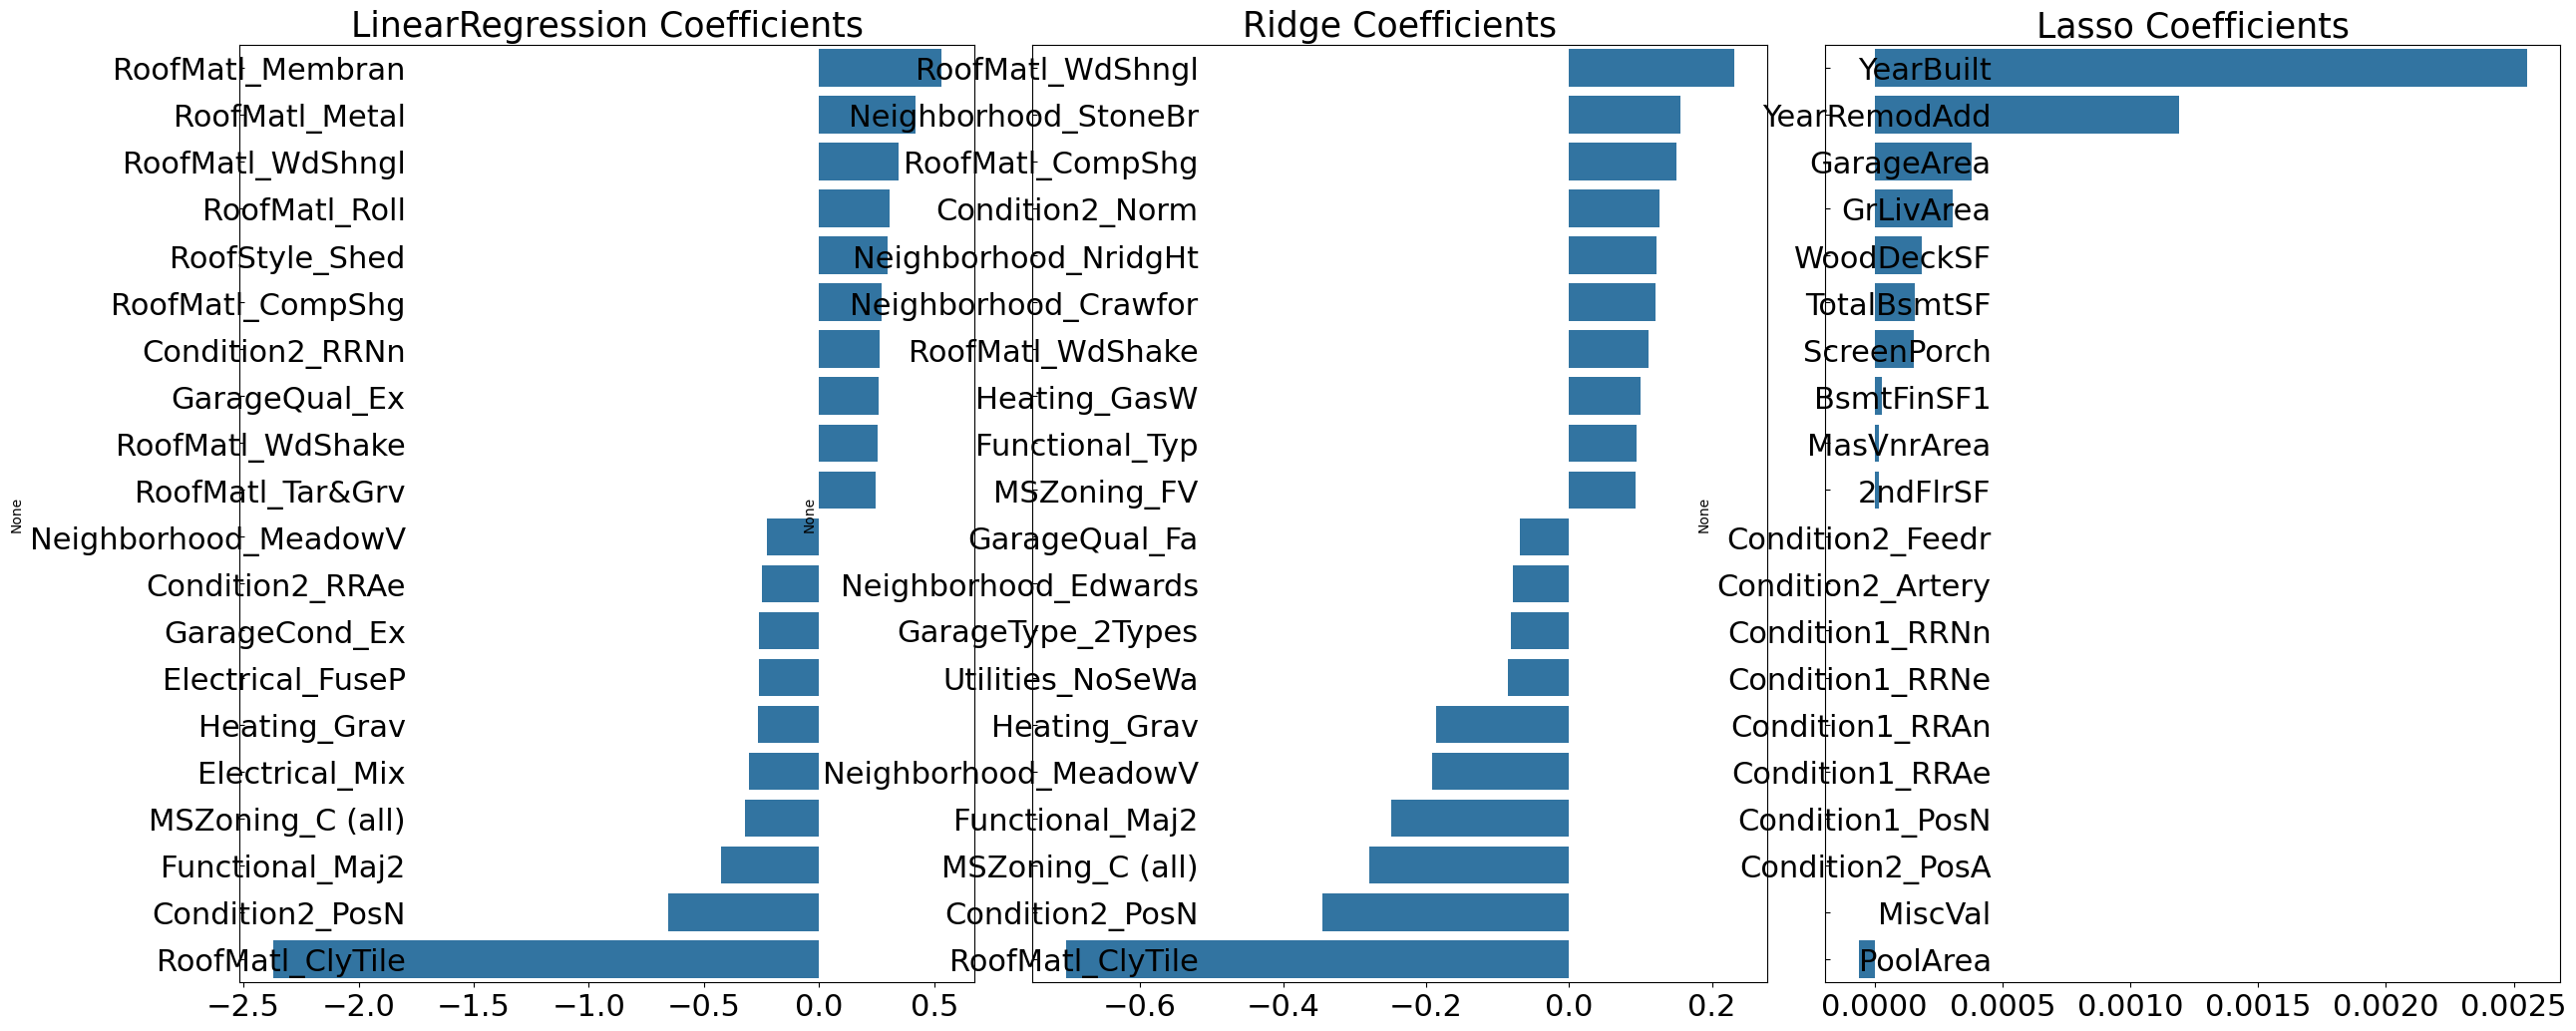

In [29]:
def visualize_coefficient(models):
  # 3개 회귀 모델의 시각화를 위해 3개 칼럼을 가지는 subplot 생성
  fig, axs = plt.subplots(figsize=(24,10), nrows=1, ncols=3)
  fig.tight_layout()

  # 입력 인자로 받은 list 객체인 models에서 차례로 model을 추출해 회귀 계수 시각화
  for i_num, model in enumerate(models):
    # 상위 10개, 하위 10개 회귀 계수를 구하고 이를 concat(결합 함수)으로 결합
    coef_high, coef_low = get_top_bottom_coef(model)
    coef_concat = pd.concat([coef_high, coef_low])

    # ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정
    axs[i_num].set_title(model.__class__.__name__+' Coefficients', size=25)
    axs[i_num].tick_params(axis="y", direction="in", pad=-120)
    for label in (axs[i_num].get_xticklabels()+axs[i_num].get_yticklabels()):
      label.set_fontsize(22)
    sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

- 모델별 회귀 계수를 보면 OLS 기반의 LinearRegression과 Ridge의 경우는 회귀 계수가 유사한 형태로 분포
- 하지만 라쏘(Lasso)는 전체적으로 회귀 계수 값이 매우 작고, 그중에 YearBuilt가 가장 크고 다른 피처의 회귀 계수는 너무 작음
- 라쏘의 경우 다른 두 개의 모델과 다른 회귀 계
수 형태를 보이고 있음
- 아래 코드로 학습 데이터 분할에 문제가 있는 것인지 확인

In [30]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):

  for model in models:
    rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                         scoring="neg_mean_squared_error", cv=5))
    rmse_avg = np.mean(rmse_list)
    print('\n{0} CV 평균 RMSE 값 리스트: {1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
    print('{0} CV 평균 RMSE 값: {1}'.format(model.__class__.__name__, np.round(rmse_avg,3)))

# 앞 예제에서 학습한 ridge, lasso 모델의 CV RMSE 값 출력
models = [ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


Ridge CV 평균 RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값: 0.144

Lasso CV 평균 RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값: 0.198


- 5개의 교차 검증 폴드 세트로 평가해도 여전히 릿지보다 성능이 떨어짐
- 아래 코드로 alpha를 변화시키며 최적 값 도출

In [31]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
  grid_model = GridSearchCV(model, param_grid = params, scoring='neg_mean_squared_error', cv=5)
  grid_model.fit(X_features, y_target)
  rmse = np.sqrt(-1*grid_model.best_score_)
  print('{0} 5 CV 시 최적 평균 RMSE 값:{1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                                           np.round(rmse,4), grid_model.best_params_))
ridge_params = {'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1418, 최적 alpha:{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값:0.142, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.124
Lasso 로그 변환된 RMSE: 0.12


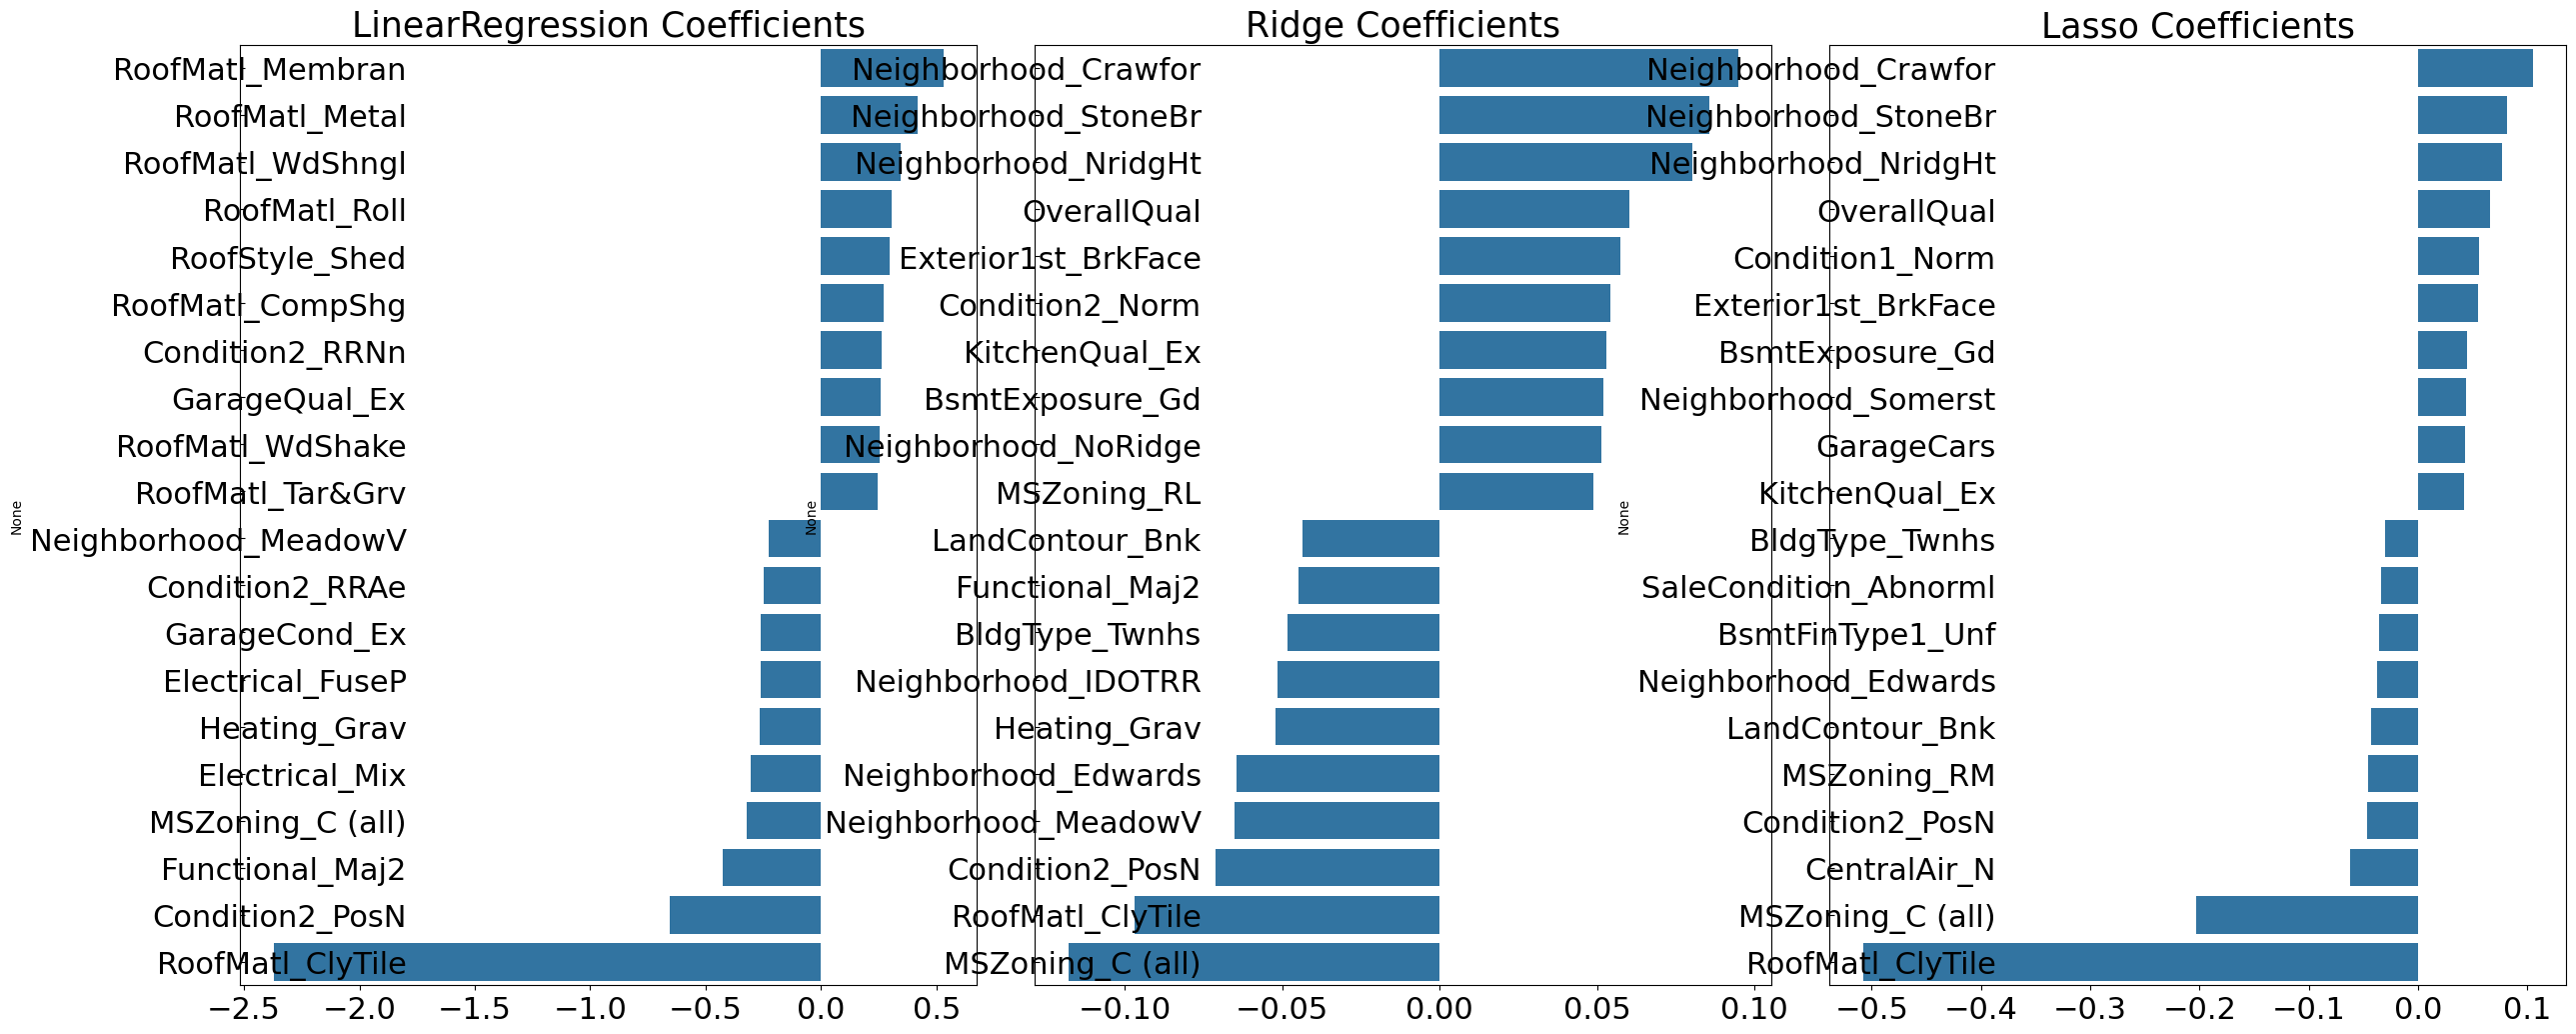

In [32]:
# 앞의 최적화 alpha 값으로 학습 데이터로 학습 & 테스트 데이터로 예측 및 평가 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)   # 최적값
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)   # 최적값
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

- alpha 값 최적화 후 테스트 데이터 세트의 예측 성능이 더 좋아짐
- 모델별 회귀 계수도 많이 달라짐
- 기존에는 라쏘 모델의 회귀 계수가 나머지 두 개 모델과 많은 차이가 있었지만, 이번에는 릿지와 라쏘 모델에서 비슷한 피처의 회귀 계수가 높음
- 다만 라쏘 모델의 경우는 릿지에 비해 동일한 피처라도 회귀 계수의 값이 상당히 작음

< 타깃 데이터 세트의 데이터 분포도의 왜곡 확인 >
- 일반적으로 skew( ) 함수의 반환 값이 1 이상인 경우를 왜곡 정도가 높다고 판단

In [33]:
from scipy.stats import skew

# object가 아닌 '숫자형' 피처의 칼럼 index 객체 추출
# 주의 : 원핫 인코딩 된 숫자형 피처는 제외
features_index = house_df.dtypes[house_df.dtypes!='object'].index

# house_df에 칼럼 index를 []로 입력하면, 해당하는 칼럼 데이터 세트 반환, apply lambda로 skew() 호출
skew_features = house_df[features_index].apply(lambda x: skew(x))

# skew(왜곡) 정도가 1 이상인 칼럼만 추출
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [34]:
# 왜곡 정도가 높은 피처 로그 변환
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [35]:
# 왜곡 정도가 높은 피처를 로그 변환했으므로 다시 원-핫 인코딩을 적용하고 피처/타깃 데이터 세트 생성
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 피처를 로그 변환한 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = {'alpha':[0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1275, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1252, 최적 alpha:{'alpha': 0.001}


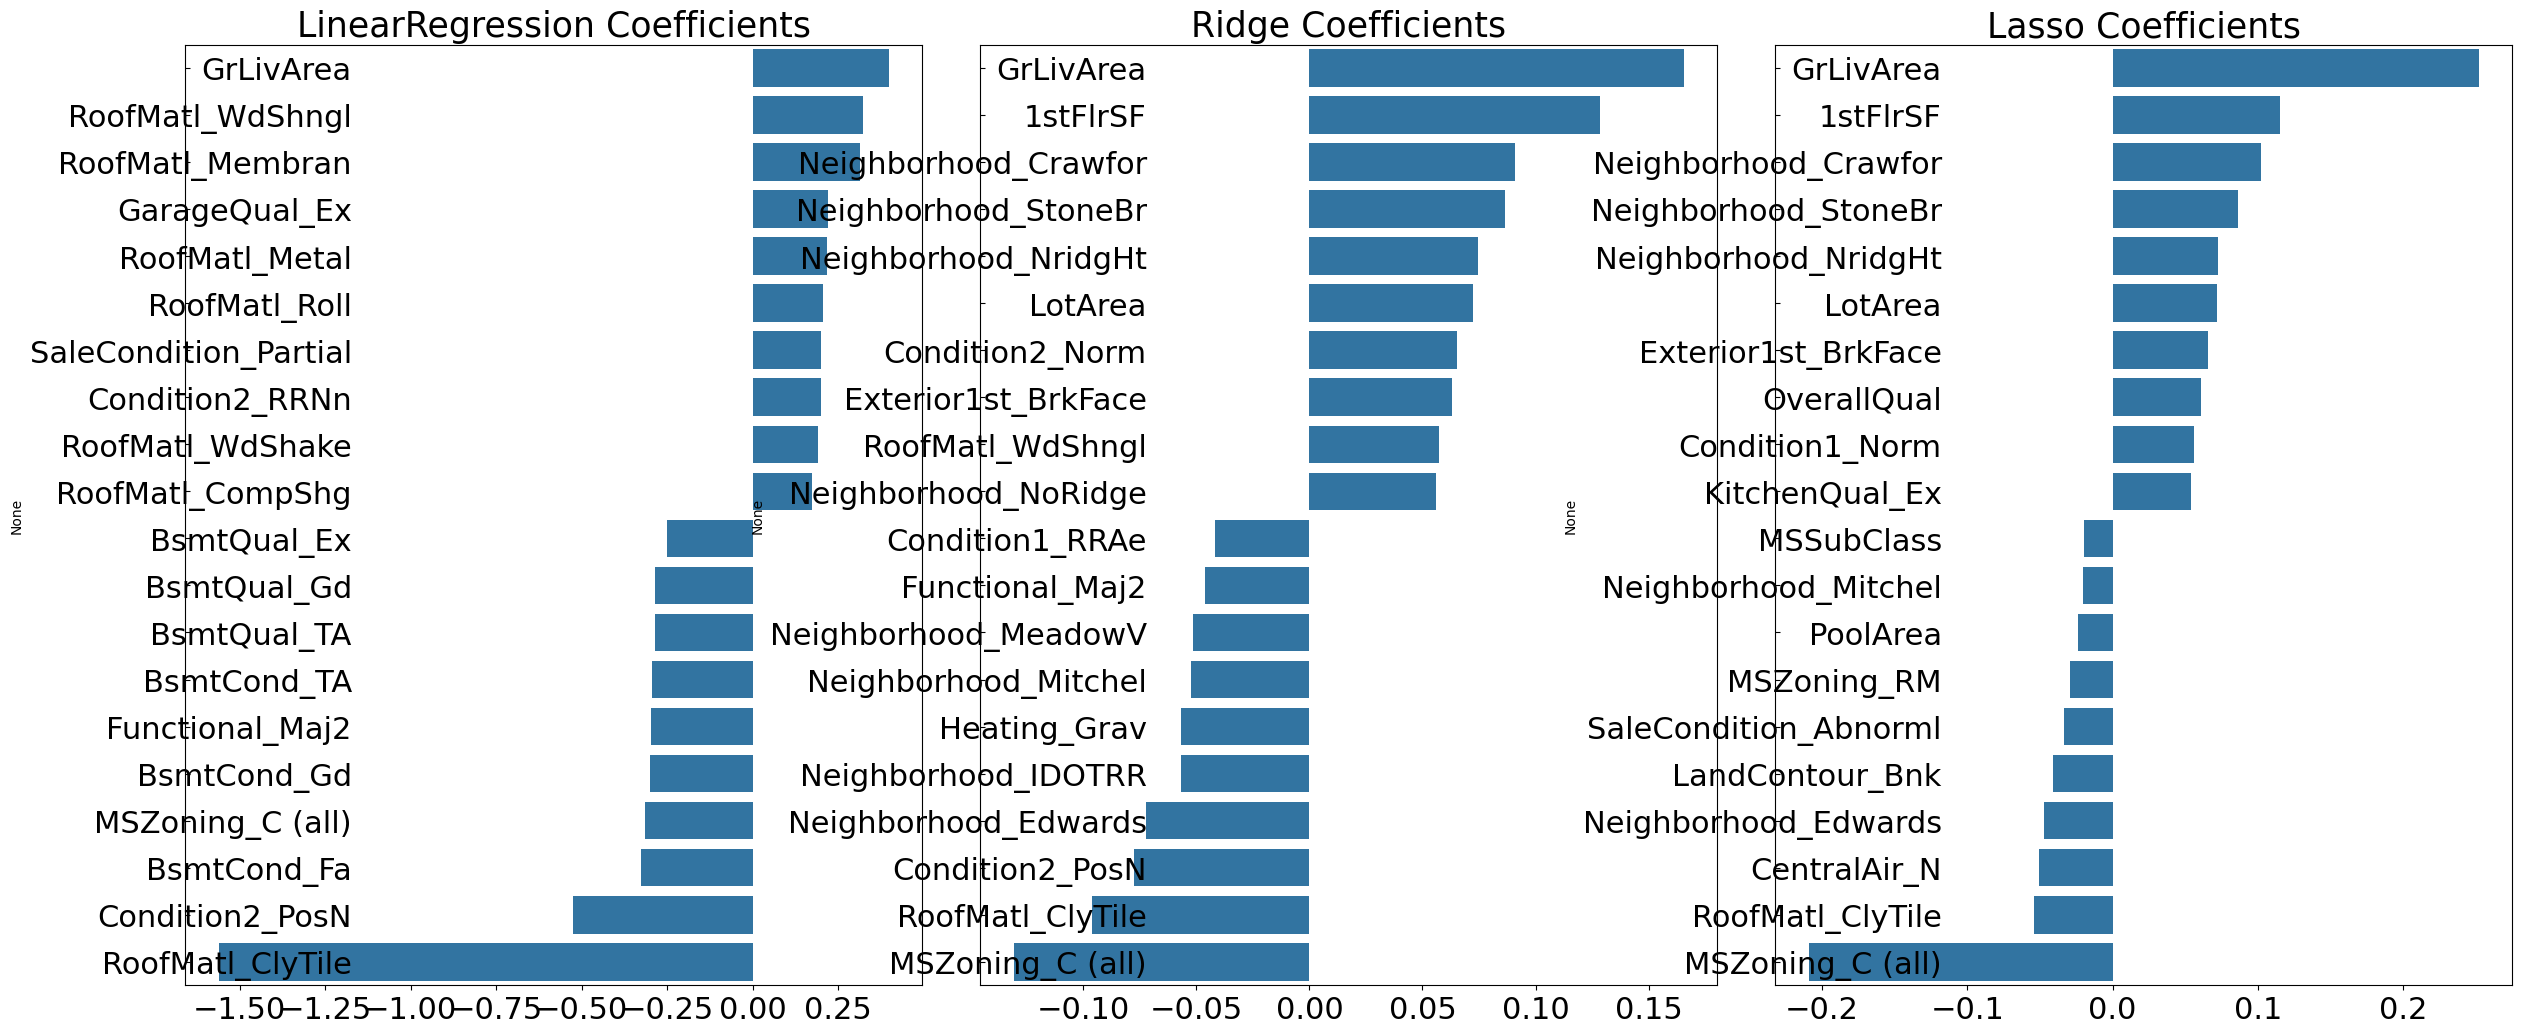

In [36]:
# 앞의 최적화 alpha 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

- 세 모델 모두 GrLivArea, 즉 주거 공간 크기가 회귀 계수가 가장 높은 피처

< 이상치 데이터 처리 >

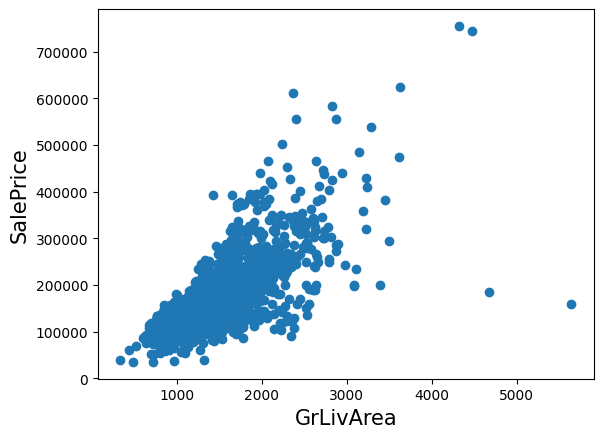

In [37]:
plt.scatter(x = house_df_org['GrLivArea'], y = house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

In [38]:
# GrLivArea와 SalePrice 모두 로그 변환됐으므로 이를 반영한 조건 생성
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('이상치 레코드 index :',outlier_index.values)
print('이상치 삭제 전 house_df_ohe shape :',house_df_ohe.shape)

# DataFrame의 인덱스를 이용해 이상치 레코드 삭제
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 house_df_ohe shape :',house_df_ohe.shape)

이상치 레코드 index : [ 523 1298]
이상치 삭제 전 house_df_ohe shape : (1460, 270)
이상치 삭제 후 house_df_ohe shape : (1458, 270)


In [39]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params = {'alpha':[0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1125, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1122, 최적 alpha:{'alpha': 0.001}


- 단 두개의 이상치 데이터만 제거했는데 예측 수치가 매우 크게 향상됨

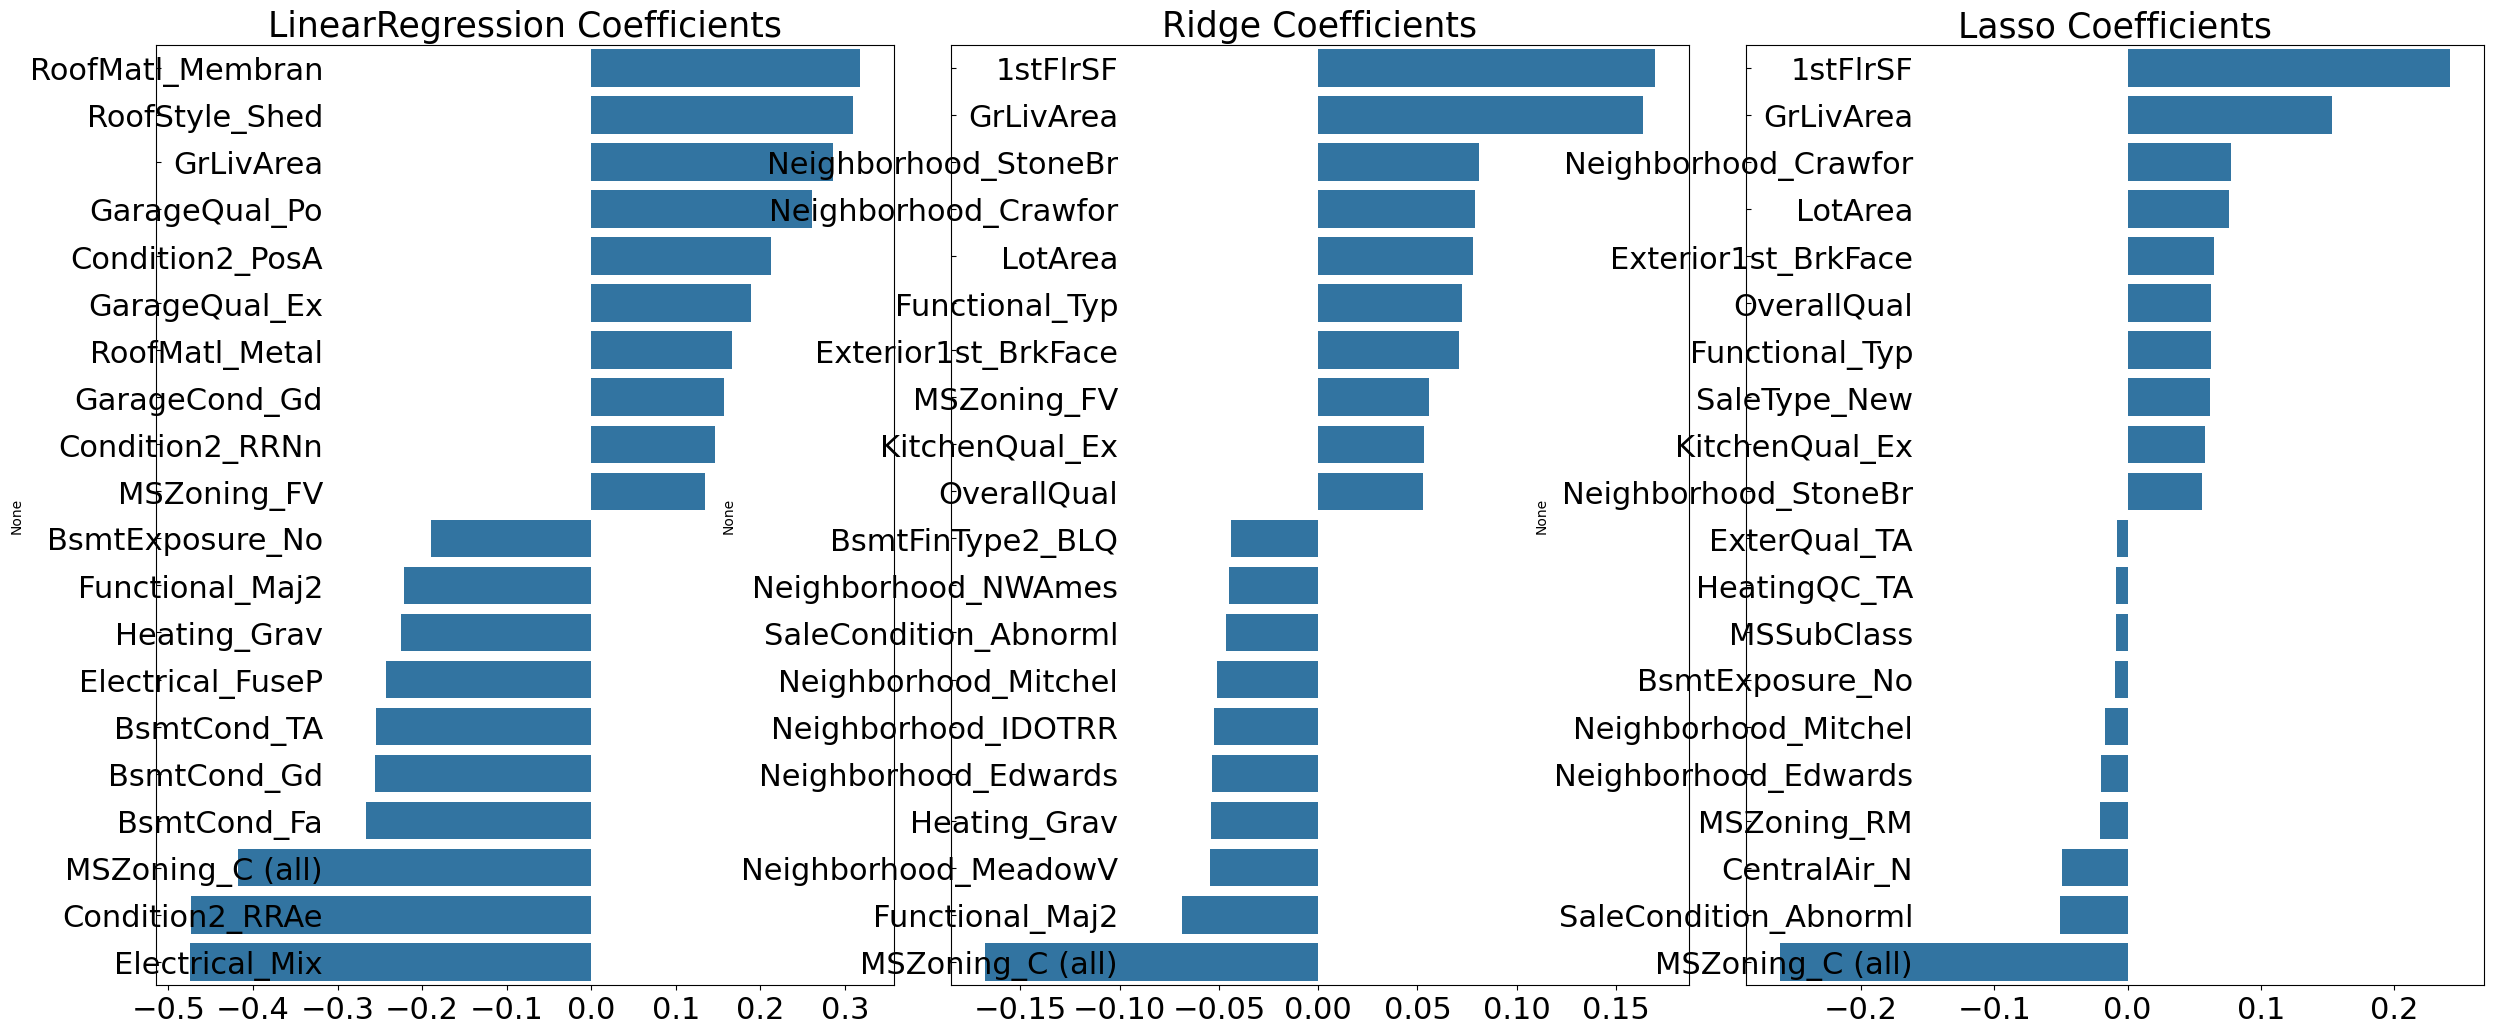

In [49]:
# 앞의 최적화 alpha 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

## 회귀 트리 모델 학습/예측/평가

In [40]:
from xgboost import XGBRegressor

xgb_params={'n_estimators':[1000]}
xgb_reg=XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값:0.1206, 최적 alpha:{'n_estimators': 1000}


In [41]:
from lightgbm import LGBMRegressor

lgbm_params={'n_estimators':[1000]}
lgbm_reg=LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,
                       subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
print_best_params(lgbm_reg, lgbm_params)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3155
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 171
[LightGBM] [Info] Start training from score 12.021352
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3167
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 168
[LightGBM] [Info] Start training from score 12.023516
[LightGBM] [Warning] Found

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3174
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 172
[LightGBM] [Info] Start training from score 12.025343


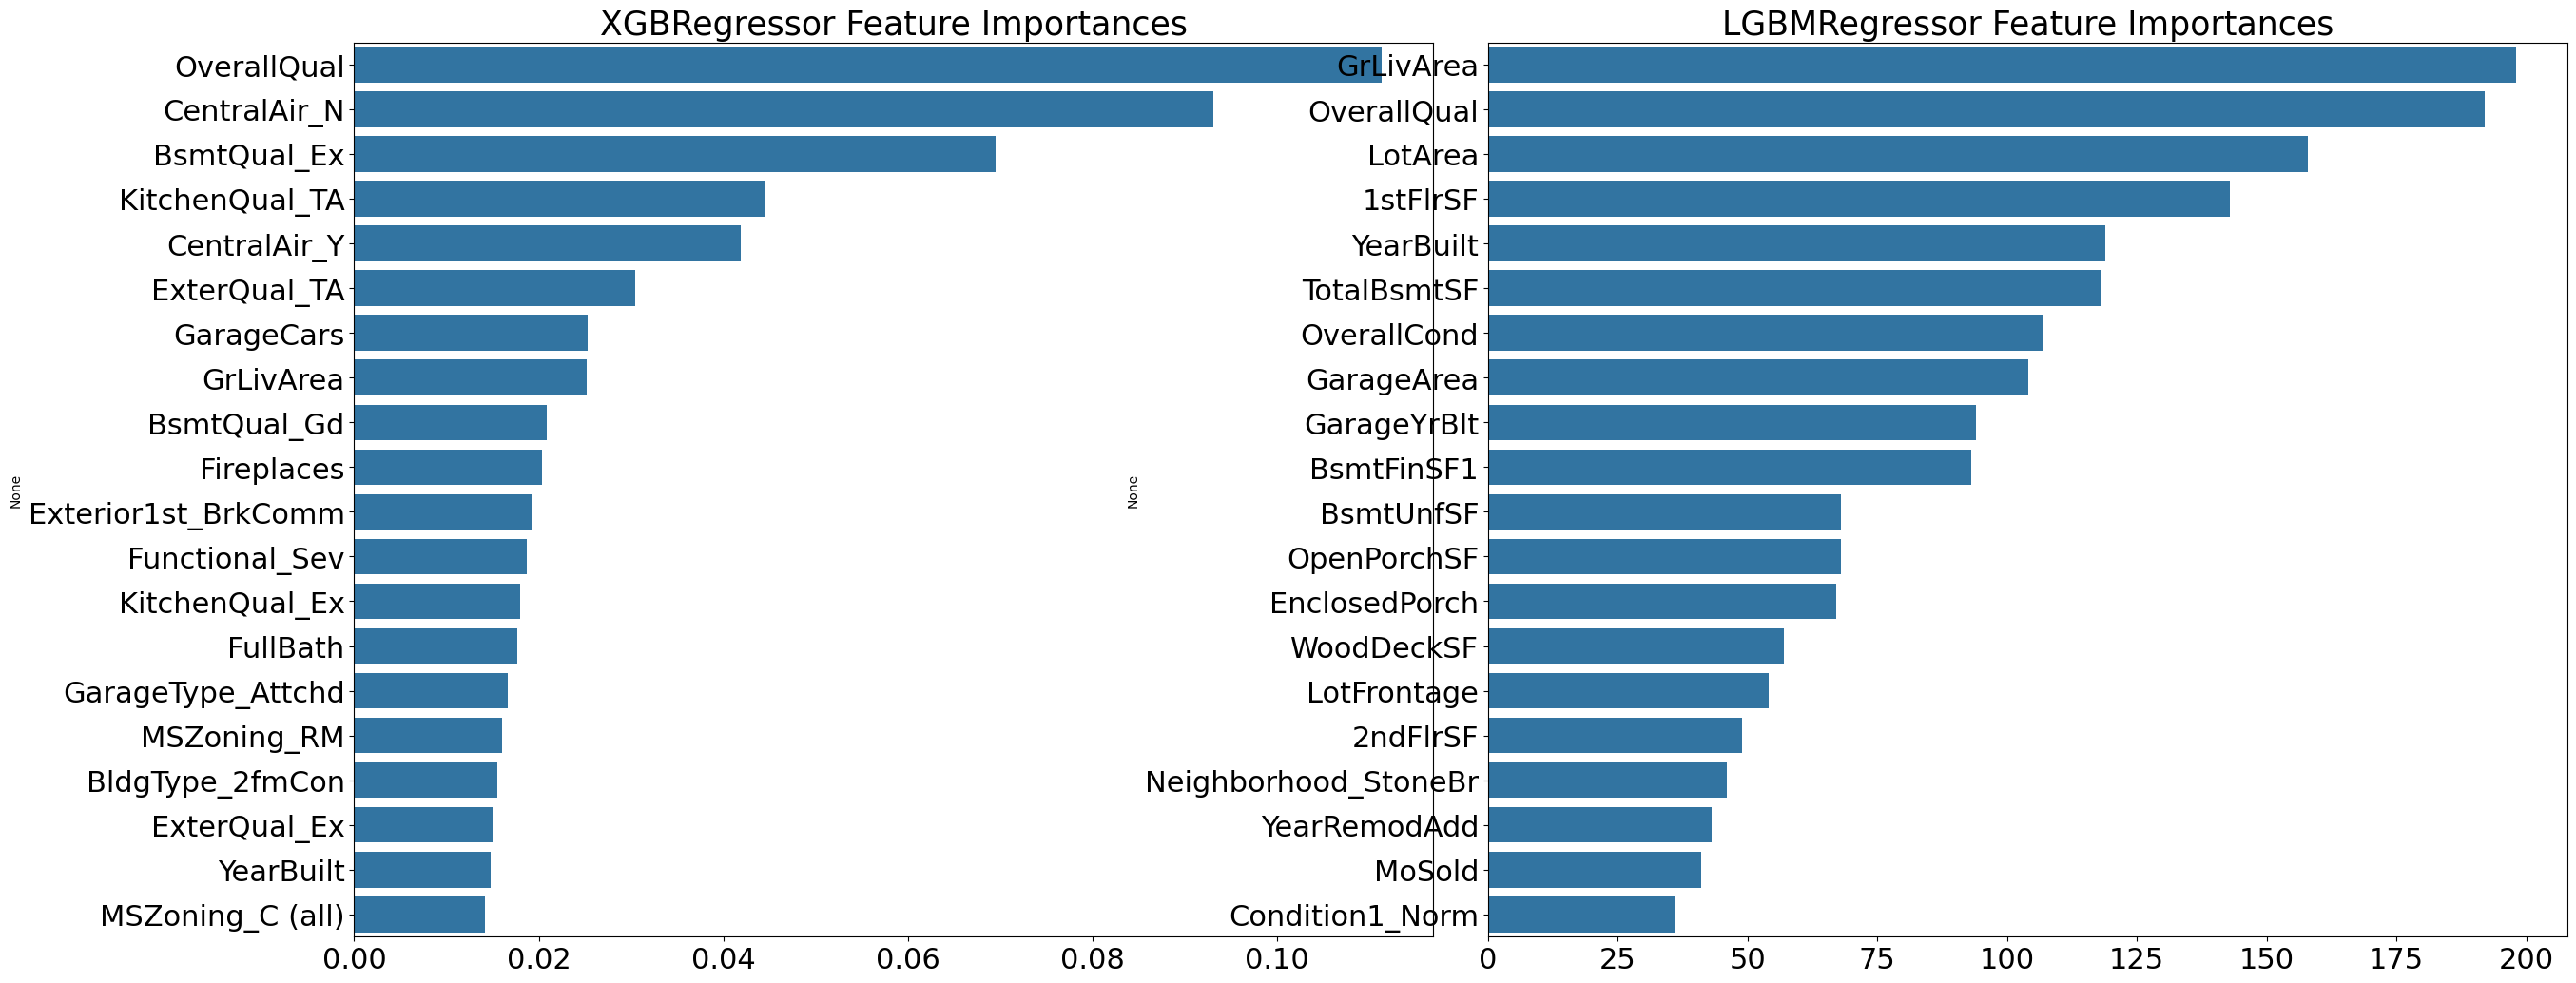

In [43]:
def get_top_features(model):
    ftr_importances_values=model.feature_importances_
    ftr_importances=pd.Series(ftr_importances_values, index=X_features.columns)
    ftr_top20=ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_importances(models):
    fig, axs=plt.subplots(figsize=(24,10), nrows=1, ncols=2)
    fig.tight_layout()
    for i_num, model in enumerate(models):
        model.fit(X_train, y_train)
        ftr_top20=get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index, ax=axs[i_num])

models=[xgb_reg, lgbm_reg]
visualize_importances(models)

## 회귀 모델의 예측 결과 혼합을 통한 최종 예측

***A x 0.4 + B x 0.6 = 최종 회귀 값***

In [42]:
def get_rmse_pred(preds):
  for key in preds.keys():
    pred_value = preds[key]
    mse = mean_squared_error(y_test, pred_value)
    rmse = np.sqrt(mse)
    print('{0} 모델의 RMSE： {1}'.format(key, rmse))

# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합':pred, 'Ridge':ridge_pred, 'Lasso':lasso_pred}

# 최종 혼합 모델, 개별 모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE： 0.10006075517615193
Ridge 모델의 RMSE： 0.10340697165289348
Lasso 모델의 RMSE： 0.10024171179335342


- 최종 혼합 모델의 RMSE가 개별 모델보다 성능 면에서 약간 개선됨
- 릿지 모델 예측값에 0.4를 곱하고 라쏘 모델 예측값에 0.6을 곱한 뒤 더함
- 0.4나 0.6을 정하는 특별한 기준은 없으며, 그냥 두 개 중 성능이 조금 좋은 쪽에 가중치를 약간 더 둔 것

In [45]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)

xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5*xgb_pred + 0.5*lgbm_pred
preds = {'최종 혼합':pred,
         'XGBM':xgb_pred,
         'LGBM':lgbm_pred}

get_rmse_pred(preds)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3174
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 172
[LightGBM] [Info] Start training from score 12.025343
최종 혼합 모델의 RMSE: 0.10215383402419025
XGBM 모델의 RMSE: 0.10761344291735733
LGBM 모델의 RMSE: 0.10363891833477148


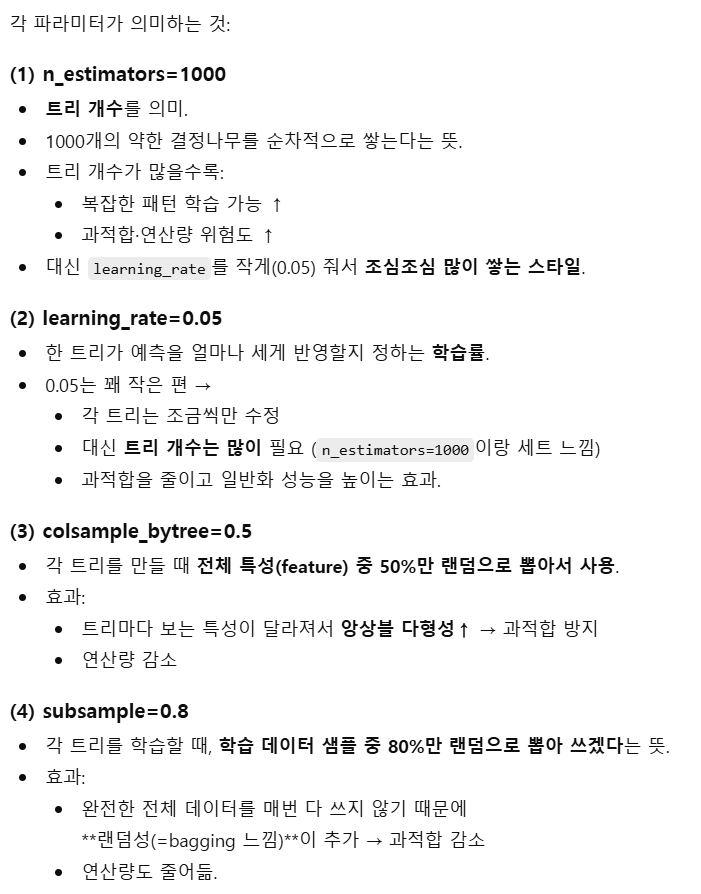

- XGBoost와 LightGBM의 혼합 모델의 RMSE가 개별 모델의 RMSE보다 조금 향상됨

## 스태킹 앙상블 모델을 통한 회귀 예측

- 스태킹 모델은 두 종류의 모델이 필요
> 첫 번째는 개별적인 기반 모델, 두 번째는 이 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습하는 최종 메타 모델
- 스태킹 모델의 핵심: 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합해 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것
- 최종 메타 모델이 학습할 피처 데이터 세트 = 원본 학습 피처 세트로 학습한 개별 모델의 예측값을 스태킹 형태로 결합한 것

In [46]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 테이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):

    # 지정된 n_folds 값으로 KFold 생성
    kf = KFold(n_splits=n_folds, shuffle=False)

    # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__, 'model 시작')

    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print('\t 폴드 세트:', folder_counter, '시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr, y_tr)

        # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
        train_fold_pred[valid_index,:] = model.predict(X_te).reshape(-1,1)

        # 입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장
        test_pred[:, folder_counter] = model.predict(X_test_n)

    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

    # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean

- get_stacking_base_datasets()는 인자로 개별 기반 모델, 그리고 원래 사용되는 학습 데이터와 테스
트용 피처 데이터를 입력받음
- 함수 내에서는 개별 모델이 K-폴드 세트로 설정된 폴드 세트 내부에서 원본의 학습 데이터를 다시 추출해 학습과 예측을 수행한 뒤 그 결과를 저장
- 저장된 예측 데이터는 추후에 메타 모델의 학습 피처 데이터 세트로 이용됨
- 또한 함수 내에서 폴드 세트 내부 학습 데이터로 학습된 개별 모델이 인자로 입력된 원본 테스트 데이터를 예측한 뒤, 예측 결과를 평균해 테스트 데이터로 생성

In [47]:
# get_stacking_base_datasets()는 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
Lasso model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
XGBRegressor model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
LGBMRegressor model 시작
	 폴드 세트: 0 시작
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2924
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 156
[LightGBM] [Info] Start training from score 12.035561
	 폴드 세트: 1 시작
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2951
[LightGBM] [Info] Num

In [48]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 스태킹 형태로 결합
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용
meta_model_lasso = Lasso(alpha=0.0005)

# 개별 모델 예측값을 기반으로 새롭게 만들어진 학습/테스트 데이터로 메타 모델 예측 및 RMSE 측정
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

스태킹 회귀 모델의 최종 RMSE 값은: 0.09704503149148055
